In [26]:
from scipy.signal import find_peaks
from scipy.linalg import hankel
import matplotlib.pyplot as plt
import seaborn as sns
from sdpa_common import *

In [4]:
xmin, xmax, N = -10, 10, 32768
spectrum1 = solveTISE(xmin, xmax, N, lambda x: x ** 4 / 4 - x, 8)

In [5]:
xmin, xmax, N = -10, 10, 32768
spectrum = solveTISE(xmin, xmax, N, lambda x: x ** 4 / 4 + np.abs(x), 8)

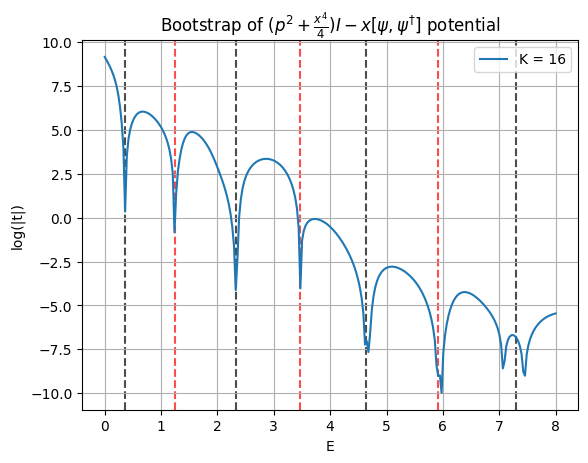

In [6]:
# Plot exact energy eigenvalues
for E in spectrum1:
    plt.axvline(x=E,ls='--',c='black',alpha=0.7,zorder=-2)
for E in spectrum:
    plt.axvline(x=E,ls='--',c='red',alpha=0.7,zorder=-2)
data = np.load('./data/x4pot_susy_k16_take2.npz', allow_pickle=True)
sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 16')
peaks = find_peaks(-np.log(np.fabs(data['ts'])),prominence=1)[0]
dips = data['Es'][peaks]
plt.title(r'Bootstrap of $(p^2 + \frac{x^4}{4})I - x[\psi, \psi^{\dagger}]$ potential')
plt.xlabel('E')
plt.ylabel(r'log(|t|)')
# plt.xlim(-1,2)
# sns.despine()
plt.grid()
plt.legend()
plt.show()


In [ ]:
class SUSYProblem(HankelProblem):
    """
    Solves H = p^2 + A(x) - B(x)[P, P\dag].
    A(x) and B(x) are polynomials provided as coefficient lists.
    """
    def __init__(self, K, problem_name, A, B):
        super().__init__(K, problem_name)
        self._A = A
        self._dA = A.shape[0] - 1
        self._B = B
        self._dB = B.shape[0] - 1

    def _initialize_basis(self):
        self._basis = [None] * 2
        self._basis[0] = [symbols(f'x^{i}PP\dag') for i in range(2*self._K)]
        self._basis[1] = [symbols(f'x^{i}P\dagP') for i in range(2*self._K)]

    def _implement_recursion(self):
        # Normalization condition
        self._basis[0][0] = self._basis[0][0].subs({'x^0PP\dag': mp.mpf('1')})
        self._basis[1][0] = self._basis[1][0].subs({'x^0P\dagP': mp.mpf('0')})

        for t in range(1, len(self._basis[0]) - self._dA + 1):
            ti = mp.mpf(t)
            # Recursion for <xPP\dag>
            self._basis[0][t + self._dA - 1] = 4*ti*self._E*self._basis[0][t-1]
            if t >= 3:
                self._basis[0][t + self._dA - 1] += ti*(ti-1)*(ti-2)*self._basis[0][t-3]
            for n in range(self._dA):
                self._basis[0][t + self._dA - 1] -= (4*ti + 2*n)*self._A[n]*self._basis[0][t+n-1]
            for n in range(self._dB + 1):
                self._basis[0][t + self._dA - 1] += (4*ti + 2*n)*self._B[n]*self._basis[0][t+n-1]
            self._basis[0][t + self._dA - 1] /= 2*self._A[-1]*(2*ti+self._dA)

            # Recursion for <xP\dagP>
            self._basis[1][t + self._dA - 1] = 4*ti*self._E*self._basis[1][t-1]
            if t >= 3:
                self._basis[1][t + self._dA - 1] += ti*(ti-1)*(ti-2)*self._basis[1][t-3]
            for n in range(self._dA):
                self._basis[1][t + self._dA - 1] -= (4*ti + 2*n)*self._A[n]*self._basis[1][t+n-1]
            for n in range(self._dB + 1):
                self._basis[1][t + self._dA - 1] -= (4*ti + 2*n)*self._B[n]*self._basis[1][t+n-1]
            self._basis[1][t + self._dA - 1] /= 2*self._A[-1]*(2*ti+self._dA)
    
    def _generate_internal_matrix_structure(self):
        M0 = hankel(self._basis[0][:self._K], self._basis[0][self._K:]) #<xPP\dag>
        M1 = hankel(self._basis[1][:self._K], self._basis[1][self._K:]) #<xP\dagP>
        Z = np.zeros_like(M0)

        self._internal_matrix = np.block(
            [[M0, Z],
             [Z, M1]])

    def _write_input(self, energy, file):
        with redirect_stdout(file):
            print(f'*Energy: {energy}')
            print('*Potential name: ' + self._name)
            print(1 + len(self._freevars)) # mDIM
            print(2) # nBLOCK
            N = self._internal_matrix.shape[0] // 2
            print(N, N) # bLOCKsTRUCT
            c = np.zeros(1 + len(self._freevars))
            c[-1] = 1
            print(*c)
            for F in self._Fs:
                for i in range(N):
                    for j in range(N):
                        if hasattr(F[i, j], 'subs'):
                            print(mp.mpf(F[i, j].subs({self._E: energy})), end =' ')
                        else:
                            print(mp.mpf(F[i, j]), end=' ')
                for i in range(N, 2 * N):
                    for j in range(N, 2 * N):
                        if hasattr(F[i, j], 'subs'):
                            print(mp.mpf(F[i, j].subs({self._E: energy})), end =' ')
                        else:
                            print(mp.mpf(F[i, j]), end=' ')
                print()

In [37]:
A = np.array([0., 0., 0., 0., 0.25])
B = np.array([0., 1.])
K = 14
p2 = SUSYProblem(K, 'x4pot', A, B)
p2.initialize_problem()

In [38]:
Es = np.linspace(0, 6, num=100)
ts = solve(p2, Es)

In [22]:
xmin, xmax, N = -10, 10, 32768
spectrum = solveTISE(xmin, xmax, N, lambda x: x ** 4 / 4 - x, 6)

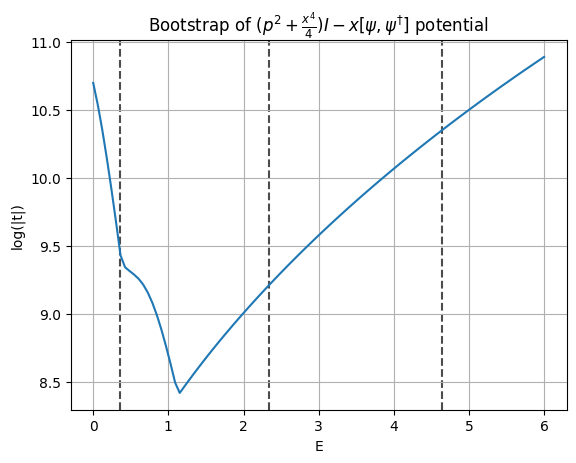

In [39]:
# Plot exact energy eigenvalues
for E in spectrum:
    plt.axvline(x=E,ls='--',c='black',alpha=0.7,zorder=-2)

# data = np.load('x2pot_susy_k10_take2.npz',allow_pickle=True)
# sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 10')
# data = np.load('x2pot_susy_k14.npz',allow_pickle=True)
# sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 14')
# data = np.load('x2pot_susy_k16_take2.npz',allow_pickle=True)
# sns.lineplot(x=data['Es'], y=np.log(np.fabs(data['ts'])),label='K = 16')
sns.lineplot(x=Es, y=np.log(np.abs(ts)))
plt.title(r'Bootstrap of $(p^2 + \frac{x^4}{4})I - x[\psi, \psi^{\dagger}]$ potential')
plt.xlabel('E')
plt.ylabel(r'log(|t|)')
# plt.xlim(-1,2)
# sns.despine()
plt.grid()
# plt.legend()
plt.show()